In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function, division
import os, sys
import numpy as np, scipy as sp, pandas as pd
import scipy.io
import scipy.signal as signal, scipy.fftpack as ftpk, scipy.integrate as integrate, scipy.interpolate as interpolate
import matplotlib.pyplot as plt
import matplotlib
import tensorflow as tf
import tflearn

original_dir = os.getcwd()

In [3]:
PLOT=False

In [4]:
e = np.exp(1)
pi = np.pi
pii = np.pi*1j
twopi = np.pi * 2
SR=400

In [5]:
import pywt
# import pyhht

In [6]:
from imp import reload
import auxfilter
import glob

In [7]:
os.chdir(original_dir + '/..')
# os.chdir('/home/mike/venvs/ml/ml/py')
print(os.getcwd())
from eegkaggle.vectorizers import naive, spectral
from eegkaggle.dio import dataio
from eegkaggle.plotting import plotstuff
from eegkaggle.msignal import wavelets, metrics

/home/mike/venvs/ml/ml/py


In [8]:
reload(plotstuff)
reload(dataio)

<module 'eegkaggle.dio.dataio' from 'eegkaggle/dio/dataio.pyc'>

In [9]:
matplotlib.style.use('ggplot')

In [10]:
ssmall,smed, slarge, slong = (4,3), (8,6), (16,12), (16,4)
matplotlib.rcParams['figure.figsize'] = smed

Functions

Data loading section

In [11]:
data_train = np.load('vec_1478816228.31.npy')
names_train = pd.read_csv('vec_1478816228.31_name.csv')
data_test = np.load('vec_1478825795.45.npy')
names_test = pd.read_csv('vec_1478825795.45_name.csv')

In [12]:
data_train = np.nan_to_num(data_train)
data_test = np.nan_to_num(data_test)

In [13]:
names_train['label'] = [ int(name[-5]) for name in names_train['path']]
print(names_train.shape, names_train['label'].mean())
names_train.head()

(6041, 3) 0.0743254428075


,Unnamed: 0,path,label
0,0,/media/mike/Elements/data/kaggle/melbourne/tra...,0
1,1,/media/mike/Elements/data/kaggle/melbourne/tra...,0
2,2,/media/mike/Elements/data/kaggle/melbourne/tra...,0
3,3,/media/mike/Elements/data/kaggle/melbourne/tra...,0
4,4,/media/mike/Elements/data/kaggle/melbourne/tra...,0


In [14]:
name_mask = names_train['label'] == 0
name_mask1 = ~name_mask # not necessary, I just goof'd
print(name_mask.shape, name_mask.mean())
name_mask.head()

(6041,) 0.925674557193


0    True
1    True
2    True
3    True
4    True
Name: label, dtype: bool

In [15]:
d0 = data_train * name_mask.reshape([6041,1,1])
d1 = data_train* ~name_mask.reshape([6041,1,1])
n0, n1 = np.count_nonzero(d0[:,512,0]), np.count_nonzero(d1[:,512,0])
print(n0, n1)

/home/mike/venvs/ml/ml/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if __name__ == '__main__':
/home/mike/venvs/ml/ml/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  from ipykernel import kernelapp as app


5536 434


In [16]:
if PLOT: plt.plot(np.mean(np.mean(data_train, axis=2)==0, axis=1))

In [17]:
if PLOT: plt.plot(np.mean(data_train, axis=0))
'Average (LOGT) power by channel'

'Average (LOGT) power by channel'

In [18]:
if PLOT: plt.plot(np.sum(d0, axis=0) / n0, c='k')
if PLOT: plt.plot(np.sum(d1, axis=0) / n1, c='r')

'data set 0 vs 1'


'data set 0 vs 1'

In [19]:
if PLOT: plt.plot(np.mean(np.sum(d0, axis=0) / n0, axis=1), c='k')
if PLOT: plt.plot(np.mean(np.sum(d1, axis=0) / n1, axis=1), c='r')

# NICE!

In [20]:
simple_dtrain = np.mean(data_train, axis=2) # avg along electrodes
simple_dtest = np.mean(data_test, axis=2)
print(simple_dtrain.shape, simple_dtest.shape)

(6041, 1024) (1908, 1024)


In [21]:
y = np.vstack([name_mask, ~name_mask]).T # label vector will be (N, S), N hot for 'no seiz', S hot for 'seize'
print(y.shape)

(6041, 2)


In [22]:
dtrain_set = np.concatenate([simple_dtrain, y], axis=1)
dtrain_set.shape

(6041, 1026)

In [23]:
dframe = pd.DataFrame(dtrain_set)

In [24]:
d0 = dframe[dframe.iloc[:,-1] == 0]
d1 = dframe[dframe.iloc[:,-1] == 1]
print(d0.shape, d1.shape)
nfalse, nhit = d0.shape[0], d1.shape[0]

(5592, 1026) (449, 1026)


In [25]:
offset = np.random.randint(0, nfalse-nhit-1)
d0b = d0[offset:offset+nhit]
print(d0b.shape)

(449, 1026)


In [26]:
d0b_ = d0b.as_matrix()
d1_ = d1.as_matrix()

d1_

array([[  3.28171930e+04,   3.28568903e+04,   3.28969489e+04, ...,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  3.22859850e+04,   3.23245433e+04,   3.23634520e+04, ...,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  4.39673125e+04,   4.40095505e+04,   4.40521694e+04, ...,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       ..., 
       [  1.09262214e+04,   1.09724476e+04,   1.10191024e+04, ...,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.99657903e+04,   2.00145807e+04,   2.00638195e+04, ...,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.34230702e+04,   1.34413036e+04,   1.34597030e+04, ...,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00]])

In [66]:
new_set = np.concatenate([d0b_, d1_], axis=0)
print(new_set.shape)
np.random.shuffle(new_set)
print(np.mean(new_set[:nhit,-1]))
simple_dtrain= new_set[:,:-2]
simple_dtrain_lab = new_set[:,-1]
simple_dtrain = simple_dtrain[:,::16]
print(simple_dtrain.shape)
print(np.mean(simple_dtrain_lab[:nhit]))


(898, 1026)
0.483296213808
(898, 64)
0.483296213808


In [67]:
simple_dtrain

array([[ 26720.00068915,  27103.38070397,  27545.11378762, ...,
          3563.08077531,   3043.4016846 ,   2502.65825038],
       [ 42332.36864744,  43170.55382943,  44136.66497712, ...,
          2802.76612278,   2256.65807056,   1917.55052123],
       [ 30199.94217582,  31037.26612079,  32005.39597013, ...,
          2517.87963455,   1950.41626518,   1638.09906321],
       ..., 
       [     0.        ,      0.        ,      0.        , ...,
             0.        ,      0.        ,      0.        ],
       [ 46047.12012835,  47130.71906637,  48380.98913452, ...,
          2087.64249963,   1802.46823816,   1538.68256084],
       [     0.        ,      0.        ,      0.        , ...,
             0.        ,      0.        ,      0.        ]])

In [68]:
# Normalize ghetto style
simple_dtrain = simple_dtrain / np.mean(simple_dtrain)
simple_dtest /= np.mean(simple_dtest)

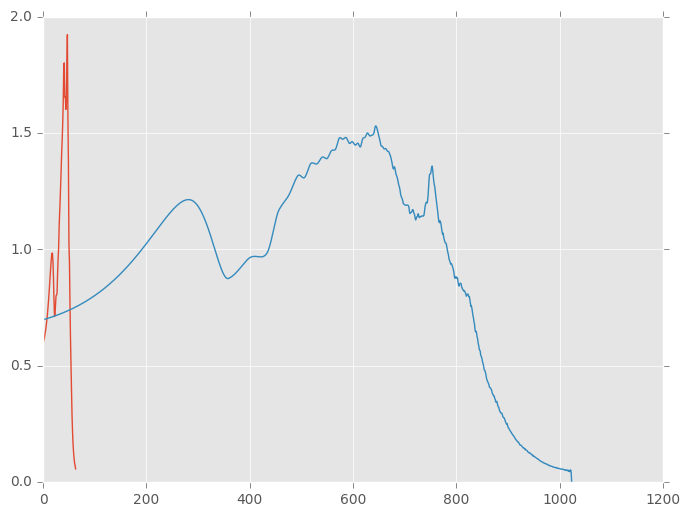

In [69]:
plt.plot(simple_dtrain[0])
plt.plot(simple_dtest[0])

In [80]:
partition = simple_dtrain.shape[0] // 2
# Build 3 layer DNN with 10, 20, 10 units respectively.
nn0 = simple_dtrain.shape[1]
nn1 = 2* nn0
nn2 = nn0
X=simple_dtrain[:partition]
Y=simple_dtrain_lab[:partition]
Xv=simple_dtrain[partition:]
Yv=simple_dtrain_lab[partition:]


In [82]:
print(Y.shape, np.mean(Y), np.mean(Yv))
print(X.shape, Xv.shape, Y.shape, Yv.shape)

(449,) 0.483296213808 0.516703786192
(449, 64) (449, 64) (449,) (449,)


In [33]:
assert 0 # break point

AssertionError: 

In [84]:
# Classification
# def do_a_graph():
# with tf.Graph().as_default(): # re-initializing the cells fucks shit up yo
tf.reset_default_graph()
tflearn.init_graph(num_cores=8, gpu_memory_fraction=0.5) # DO ONLY ONCE!

net = tflearn.input_data(shape=[None, nn0])
net = tflearn.fully_connected(net, 10)
# net = tflearn.dropout(net, 0.5)
net = tflearn.fully_connected(net, 1, activation='softmax')
net = tflearn.regression(net, optimizer='adam', loss='categorical_crossentropy')

model = tflearn.DNN(net)
model.fit(X, Y.reshape(-1,1),n_epoch=1)
# model.save('model')
    #     return model

Training Step: 8 
| Adam | epoch: 001 | loss: 0.00000 -- iter: 449/449
Training Step: 8 
| Adam | epoch: 001 | loss: 0.00000 -- iter: 449/449
--


In [85]:
# with tf.Graph().as_default(): 
#     model.load('model')
ev = model.evaluate(Xv, Yv.reshape(-1,1))
print(ev)

[1.0]


In [51]:
ev

[1.0]

In [52]:
pr = model.predict(simple_dtest)

In [53]:
pr_ = np.array(pr)

In [55]:
np.mean(pr_[:,0])

1.0

In [ ]:
pr_.shape

In [ ]:
guess = pr_[:,1] > .5
guess

In [ ]:
names_test['guess'] = pd.Series(pr_[1,:])

In [ ]:
names_test['']

In [89]:
from sklearn import linear_model as lm

In [90]:
perc = lm.Perceptron()

In [91]:
perc.fit(X, Y)

Perceptron(alpha=0.0001, class_weight=None, eta0=1.0, fit_intercept=True,
      n_iter=5, n_jobs=1, penalty=None, random_state=0, shuffle=True,
      verbose=0, warm_start=False)

In [92]:
perc.score(Xv, Yv)

0.70378619153674837

In [95]:
pr = perc.predict(simple_dtest[:,::16])
print(pr.mean())

0.787735849057


In [96]:
names_test['guess'] = pd.Series(pr)

In [100]:
names_test['File'] = [os.path.basename(name) for name in names_test['path']]

In [103]:
names_test.to_csv('guess11_10_perc.csv')

In [104]:
ls

1_1062_0_44100.wav  checkpoint           naive_train_Y.npy
1_1066_0_44100.wav  d0.png               npy_data/
1_308_0_44100.wav   d1.png               pics/
1_396_0_44100.wav   eegkaggle/           vec_1478757083.88.npy
1_404_0_44100.wav   good_pics/           vec_1478758610.36.npy
1_558_0_44100.wav   guess11_10_perc.csv  vec_1478816228.31_name.csv
1_735_0_44100.wav   model                vec_1478816228.31.npy
1_805_0_44100.wav   model.meta           vec_1478825795.45_name.csv
3_1000_0_44100.wav  naive_train_X.npy    vec_1478825795.45.npy
